In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
price = 15
max_price = 50
x = np.random.normal(0,1)


def changing_x(t):
    x = np.sin(t) + np.random.normal(0,0.5)
    return x


conversion_probability = lambda p,t: 1/(p + 2*changing_x(t))
# PROBLEM: this always generates monotonic increasing profit curves

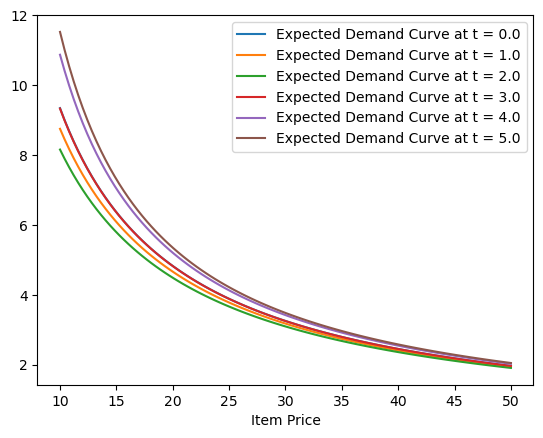

In [5]:
prices = np.linspace(10, max_price, 100)
t_interval = np.linspace(0,5,6)
n_customers = 100


for t in t_interval:
    expected_demand_curve = n_customers*conversion_probability(prices, t)

    estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices, t))

    
    plt.plot(prices, expected_demand_curve, label='Expected Demand Curve at t = {}'.format(t))
    #plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
    plt.xlabel('Item Price')
    plt.legend()
plt.show()

In [4]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost
        


    def round(self, p_t, n_t, t): #n_t is the numebr of customers at time t, p_t is the price at time t
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t, t)) #demand at time t
        r_t = (p_t - self.cost)*d_t #reward at time t
        return d_t, r_t
    